In [1]:
import pandas as pd
import numpy as np
import mne
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# Understanding data

Trying to understand more about data channels and seeing how to data needs to be processed. 

In [2]:
DATA_ROOT = '../data/ds004902-download'

In [3]:
class LoadData:
    def __init__(self, root, experiment_type: int, test_size: float = 0.2, random_state: int = 42, k_folds: int = 5, use_freqs: bool = False):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """
        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        # get class labels
        self.raw_labels = self.get_classes()
        self.labels = []

        # create data examples
        self.raw_data = []
        self.data = []
        self._create_eeg_objects()

        # holdout information
        self.test_size = test_size
        self.random_state = random_state

        # cross-validation information
        self.k_folds = k_folds
        self.split_participants = []

        # train and test data
        self.test = None
        self.train = None

        # split data
        self._cross_validation()
    

    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order
    
    def _create_eeg_objects(self): 
        def load_raw_eeg(example, root, participant_id, session, task, class_label):
            try:
                aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()

                if self.use_freqs:
                    raise NotImplementedError("Frequency bands not implemented yet")

                if class_label:
                    example[f"{task}_sd"] = (aux_eeg, class_label)
                else:
                    example[f"{task}_ns"] = (aux_eeg, class_label)
            except FileNotFoundError:
                print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")
                aux_eeg = None
            except RuntimeError as e:
                print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")
                aux_eeg = None

            return example

        session_order = self.raw_labels

        for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
            example = dict()
            if self.experiment_type == 1:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
            elif self.experiment_type == 2:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
            else:
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, self.DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)

            if len(example.keys()):
                print(example.keys())
                example['participant_id'] = participant_id

            self.raw_data.append(example) if example.keys() else None
        
        self.raw_data = np.array(self.raw_data)  


    def _holdout(self, participant_id, participant_index):
        X_train, X_test, y_train, y_test = train_test_split(participant_id, participant_index, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def _cross_validation(self):
        participant_id = np.array([x['participant_id'] for x in self.raw_data])
        participant_index = np.arange(len(participant_id))

        _, _, y_train, y_test_id = self._holdout(participant_id, participant_index)
        
        # save test data
        X_test = [self.raw_data[i][col][0] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id']
        y_test = np.array([self.raw_data[i][col][1] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id'])
        self.test = (X_test, y_test)

        # create splits
        skf = KFold(n_splits=self.k_folds)
        self.split_participants = list(skf.split(y_train))


    def get_split_data(self, split):
        split_ids = self.split_participants[split]
        train_ids, val_ids = split_ids

        X_train =[self.raw_data[i][col][0] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_train = np.array([self.raw_data[i][col][1] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id'])
                
        X_val = [self.raw_data[i][col][0] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_val = np.array([self.raw_data[i][col][1] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id'])

        return X_train, X_val, y_train, y_val

    def __len__(self):
        return len(self.raw_data)

In [4]:
data = LoadData(DATA_ROOT, 2)

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[5.21693552e-11 3.63632869e-11 2.65701138e-11 ... 4.00740221e-15
  4.34370799e-14 5.08945815e-14]
 [2.10997342e-11 1.47559674e-11 9.85245352e-12 ... 3.48528050e-15
  5.24977762e-14 6.41991375e-14]
 [4.04623154e-11 3.30045300e-11 2.24235765e-11 ... 5.00813556e-15
  6.28512367e-14 7.05493841e-14]
 ...
 [2.40552762e-11 1.58932143e-11 1.20998626e-11 ... 9.03051702e-15
  5.67367194e-14 6.25930197e-14]
 [2.35802055e-11 1.42143903e-11 1.27773775e-11 ... 2.33024169e-14
  6.83595331e-14 6.66089690e-14]
 [3.32929365e-11 2.19946654e-11 1.49993479e-11 ... 3.38044225e-14
  6.35938384e-14 5.19139629e-14]]
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Error loading participant sub-01 with 

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[2.22306328e-10 1.33683423e-10 1.33862371e-10 ... 2.20764491e-14
  2.76559222e-13 2.27684932e-13]
 [8.03407961e-11 4.54561210e-11 3.78131663e-11 ... 2.28600896e-14
  3.10573548e-13 2.50322135e-13]
 [9.68937662e-11 5.70916367e-11 4.32855051e-11 ... 2.44075048e-14
  3.29554296e-13 2.66385992e-13]
 ...
 [6.44749793e-11 4.42656010e-11 3.02983917e-11 ... 4.49473165e-14
  4.22577290e-13 3.28193744e-13]
 [3.11746177e-10 1.72805920e-10 1.20113338e-10 ... 6.26698635e-14
  4.62226047e-13 3.59484755e-13]
 [5.97274854e-11 5.12899162e-11 3.79503283e-11 ... 9.08239364e-14
  5.54653226e-13 4.13901946e-13]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[1.02789929e-10 6.87261152e-11 6.63435346e-11 ... 5.89768308e-18
  1.53792265e-17 1.04456113e-17]
 [2.64614553e-11 1.82990193e-11 1.68545659e-11 ... 4.11261451

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[4.24620219e-10 2.49790038e-10 1.47111810e-10 ... 4.66890950e-14
  6.51983609e-13 5.89257272e-13]
 [4.98172970e-10 3.30286897e-10 1.91094947e-10 ... 9.00207833e-14
  6.39601077e-13 5.01833314e-13]
 [6.21296790e-11 2.81186308e-11 2.03692105e-11 ... 3.02965931e-14
  4.01201204e-13 3.41984297e-13]
 ...
 [1.26430762e-10 7.92910013e-11 5.43552319e-11 ... 1.20757504e-13
  6.72703886e-13 5.61885660e-13]
 [4.57633277e-10 2.85037640e-10 1.62023898e-10 ... 2.61316319e-14
  3.27444136e-13 2.78682128e-13]
 [3.05884904e-11 2.04759834e-11 1.15278745e-11 ... 2.93170323e-14
  3.91627212e-13 3.42013409e-13]]
dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-52\ses-1\eeg\sub-52_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[1.70123682e-10 1.47660951e-10 1.54416763e-10 ... 3.42550368e-15
  1.22094391e-14 9.20698860e-15]
 [4.48345196e-11 3.30423968e-11 3.21231555e-11 ... 6.64846483

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


Effective window size : 4.096 (s)
[[1.09169701e-09 4.69116314e-10 2.81207704e-10 ... 1.46519800e-14
  2.72775171e-13 2.54425016e-13]
 [2.49437487e-10 1.09523875e-10 6.37954916e-11 ... 4.70893580e-15
  8.47651903e-14 7.56246741e-14]
 [9.60116881e-10 4.18004206e-10 2.27390994e-10 ... 1.03562470e-14
  5.52802555e-14 4.88966123e-14]
 ...
 [1.04149734e-10 4.57768830e-11 3.41248208e-11 ... 1.70169414e-14
  3.48586032e-13 3.29123892e-13]
 [1.09512149e-10 4.76726528e-11 3.61661125e-11 ... 3.32573814e-14
  7.12207796e-13 6.71761274e-13]
 [1.15955404e-10 5.25290767e-11 4.12527225e-11 ... 3.37559986e-14
  6.42689092e-13 6.04633270e-13]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[5.47836216e-10 4.61932117e-10 3.91013847e-10 ... 2.29710937e-17
  3.34075677e-17 1.73499536e-17]
 [5.87575170e-10 5.23933289

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]
C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[7.94279233e-10 5.85377025e-10 5.09664558e-10 ... 7.92074813e-15
  3.75082241e-14 3.21164193e-14]
 [1.96668218e-10 1.23638824e-10 1.04344370e-10 ... 8.57324404e-15
  8.70822465e-14 7.27331066e-14]
 [7.58128894e-10 3.00305020e-10 1.87022223e-10 ... 7.75448002e-15
  7.00665353e-15 4.73344850e-15]
 ...
 [8.24638437e-11 5.44328278e-11 4.16606249e-11 ... 4.76910317e-15
  4.95167044e-14 4.07501154e-14]
 [9.31993603e-11 5.68395088e-11 4.81054809e-11 ... 4.11773235e-15
  3.65183065e-14 3.00644441e-14]
 [9.92742495e-11 6.28967977e-11 4.82267801e-11 ... 6.99171751e-15
  5.65454390e-14 4.53697447e-14]]
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)


C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[2.77815186e-09 1.29804669e-09 5.84479720e-10 ... 4.12839105e-14
  5.48322962e-14 3.82764806e-14]
 [2.70780477e-09 1.18939253e-09 4.57755599e-10 ... 8.81607255e-14
  5.96052644e-14 2.95344238e-14]
 [1.49250375e-10 7.83359226e-11 5.22417498e-11 ... 4.84933260e-14
  1.13065646e-13 7.87793420e-14]
 ...
 [3.78981333e-10 1.73061497e-10 6.57346362e-11 ... 2.20189448e-14
  4.92675140e-14 2.89640696e-14]
 [2.75468599e-09 1.27357224e-09 5.16731241e-10 ... 1.51389852e-14
  5.45905065e-14 4.28006341e-14]
 [1.25490494e-10 5.33132244e-11 2.16306757e-11 ... 6.91050228e-15
  8.93938523e-14 6.33433517e-14]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[1.31459193e-10 1.53872432e-10 1.39225164e-10 ... 2.89943905e-14
  3.48172281e-14 1.61129673e-14]
 [4.07860880e-11 4.12010815e-11 3.67815114e-11 ... 1.15605524

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[8.99420369e-10 6.09050321e-10 3.28187676e-10 ... 1.14058779e-14
  1.79508752e-14 1.71228402e-14]
 [2.09986699e-10 1.50442150e-10 8.20389745e-11 ... 1.92882294e-14
  2.80709802e-14 2.49919267e-14]
 [3.91259751e-10 2.80676877e-10 1.90807551e-10 ... 5.34307773e-14
  1.18175053e-13 9.74662558e-14]
 ...
 [2.59064170e-10 1.48351132e-10 7.30553943e-11 ... 1.15697785e-14
  1.70736587e-14 8.81539901e-15]
 [2.35533005e-10 1.33663601e-10 7.06312792e-11 ... 2.85116636e-14
  3.77302520e-14 1.75062627e-14]
 [2.61704406e-10 1.39544682e-10 8.40896460e-11 ... 4.70137622e-14
  6.68936474e-14 3.57454737e-14]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[1.55340725e-10 1.13736668e-10 7.07723819e-11 ... 1.64252189e-15
  2.35466006e-15 1.96422662e-15]
 [3.60103193e-11 2.82632925e-11 1.81451222e-11 ... 8.13016001

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[2.98309475e-10 1.81520323e-10 1.40165639e-10 ... 2.52902025e-14
  4.08968131e-14 2.55771456e-14]
 [1.73285798e-10 1.47746347e-10 8.61060920e-11 ... 4.33552694e-14
  8.61634671e-14 5.61831758e-14]
 [2.79882308e-11 1.21749732e-11 1.05107628e-11 ... 3.88026892e-15
  1.05496858e-14 7.64883585e-15]
 ...
 [1.38983318e-10 6.96122283e-11 3.44868508e-11 ... 4.80732766e-13
  5.24217989e-13 1.73387187e-13]
 [1.35833776e-10 1.09749895e-10 7.30724413e-11 ... 7.76593318e-15
  2.16204508e-14 1.53569888e-14]
 [2.40882657e-11 1.67087600e-11 9.82533024e-12 ... 6.95431533e-15
  3.83877207e-14 3.49639354e-14]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)


C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[4.33364969e-09 2.38269407e-09 2.01126608e-09 ... 3.64751876e-14
  2.81246971e-14 2.04683502e-14]
 [1.02784476e-09 5.53898071e-10 4.75353882e-10 ... 6.15008704e-14
  7.35760007e-14 6.45620646e-14]
 [2.54623838e-09 1.24711845e-09 1.10926216e-09 ... 2.73626472e-13
  3.76117699e-13 1.63552955e-13]
 ...
 [2.18801689e-10 1.09585402e-10 8.32855208e-11 ... 8.36770817e-15
  1.06255139e-14 8.09121781e-15]
 [2.35707186e-10 1.12278447e-10 8.74924552e-11 ... 1.11568301e-14
  2.24051961e-14 1.74731815e-14]
 [2.38552171e-10 1.16869126e-10 9.22128267e-11 ... 1.60501817e-14
  2.48739039e-14 1.61331326e-14]]
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[2.18536051e-09 1.13906199e-09 7.80551574e-10 ... 4.54927413e-15
  1.22781994e-14 7.96102619e-15]
 [6.45918826e-10 3.42794013e-10 2.40786794e-10 ... 3.92769500e-15
  1.23871114e-14 1.04779923e-14]
 [1.

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[1.28919930e-09 8.86996795e-10 6.53781625e-10 ... 9.45569848e-15
  1.17794425e-14 4.58622349e-15]
 [2.93776417e-10 1.80778904e-10 1.34806269e-10 ... 7.98353724e-15
  1.13764994e-14 6.80522853e-15]
 [9.04168112e-10 5.26037793e-10 3.29206884e-10 ... 6.20148843e-14
  5.86394935e-14 1.88088589e-14]
 ...
 [1.86847519e-10 9.62635934e-11 6.11395966e-11 ... 6.41855122e-15
  1.17126949e-14 6.38567687e-15]
 [1.78879987e-10 9.43107772e-11 5.84032465e-11 ... 1.34631186e-14
  2.22597592e-14 1.25524533e-14]
 [2.18240659e-10 1.10583724e-10 6.87412647e-11 ... 2.39158704e-14
  3.88151453e-14 2.15665435e-14]]
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[8.48917873e-09 5.38576507e-09 1.95749413e-09 ... 1.42286323e-14
  1.23623245e-14 8.37949469e-15]
 [9.90310401e-10 7.29447569e-10 2.80911958e-10 ... 6.26683954

C:\Users\beama\AppData\Local\Temp\ipykernel_20824\3796449589.py:58: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").compute_psd(fmin=0.5, fmax=250, remove_dc=False).get_data(return_freqs=True)[0]


[[2.17041580e-10 1.05512489e-10 9.41687640e-11 ... 5.73781476e-15
  9.58055660e-15 4.83945596e-15]
 [6.36613399e-11 3.30331182e-11 2.80664513e-11 ... 3.84096493e-15
  3.62930342e-14 3.28889739e-14]
 [1.27689428e-10 7.14516084e-11 6.23714945e-11 ... 4.11203376e-15
  8.17550662e-15 6.59236518e-15]
 ...
 [6.67690273e-11 3.45021186e-11 2.28326048e-11 ... 3.75887178e-15
  1.21731943e-14 9.76324854e-15]
 [6.60652889e-11 3.54441712e-11 2.58536566e-11 ... 6.43700050e-15
  1.43472110e-14 9.97409610e-15]
 [6.29215960e-11 3.25826564e-11 2.36608425e-11 ... 8.20623978e-15
  1.12667453e-14 6.13639090e-15]]
dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
Effective window size : 4.096 (s)
[[7.44679726e-10 4.90892585e-10 3.01990220e-10 ... 3.46752103e-14
  4.73784418e-14 2.98032763e-14]
 [1.00723779e-10 7.58163874e-11 5.34728723e-11 ... 2.17404346

In [5]:
for i in range(data.k_folds):
    X_train, X_val, y_train, y_val = data.get_split_data(i)
    print(f"Fold {i}")
    print(f"Train length: {len(X_train)}")
    print(f"Train example shape: {X_train[0].shape}")
    print(f"Val length: {len(X_val)}")
    print(f"Val example shape: {X_val[0].shape}")
    print(f"Total: {len(X_train) + len(X_val)}")
    print(f"Total raw data: {len(data.raw_data)}")
    print(f"Total test data: {len(data.test[0])}")
    print("")

Fold 0
Train length: 86
Train example shape: (61, 1022)
Val length: 22
Val example shape: (61, 1022)
Total: 108
Total raw data: 71
Total test data: 29

Fold 1
Train length: 86
Train example shape: (61, 1022)
Val length: 22
Val example shape: (61, 1022)
Total: 108
Total raw data: 71
Total test data: 29

Fold 2
Train length: 87
Train example shape: (61, 1022)
Val length: 21
Val example shape: (61, 1022)
Total: 108
Total raw data: 71
Total test data: 29

Fold 3
Train length: 87
Train example shape: (61, 1022)
Val length: 21
Val example shape: (61, 1022)
Total: 108
Total raw data: 71
Total test data: 29

Fold 4
Train length: 86
Train example shape: (61, 1022)
Val length: 22
Val example shape: (61, 1022)
Total: 108
Total raw data: 71
Total test data: 29



In [6]:
X_train[0][0]

array([5.21693552e-11, 3.63632869e-11, 2.65701138e-11, ...,
       4.00740221e-15, 4.34370799e-14, 5.08945815e-14])

In [7]:
X_train[0][1]

array([2.10997342e-11, 1.47559674e-11, 9.85245352e-12, ...,
       3.48528050e-15, 5.24977762e-14, 6.41991375e-14])

In [8]:
print("index 0 shape", X_train[0][0].shape)
print("index 1 shape", X_train[0][1].shape)

index 0 shape (1022,)
index 1 shape (1022,)


In [9]:
all(X_train[1][1] == X_train[0][1])

False

In [10]:
X_train, X_val, y_train, y_val = data.get_split_data(0)

In [11]:
example = X_train[0]

In [12]:
example[0].shape

(1022,)

## Testing time to frequency conversion
Using the ['compute_psd method'](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.compute_psd). 

### Attempt #1: fmin = 0.5, fmax = 250 (values chosen due to data analysis in 01 notebook). remove_dc = True and method = multitaper

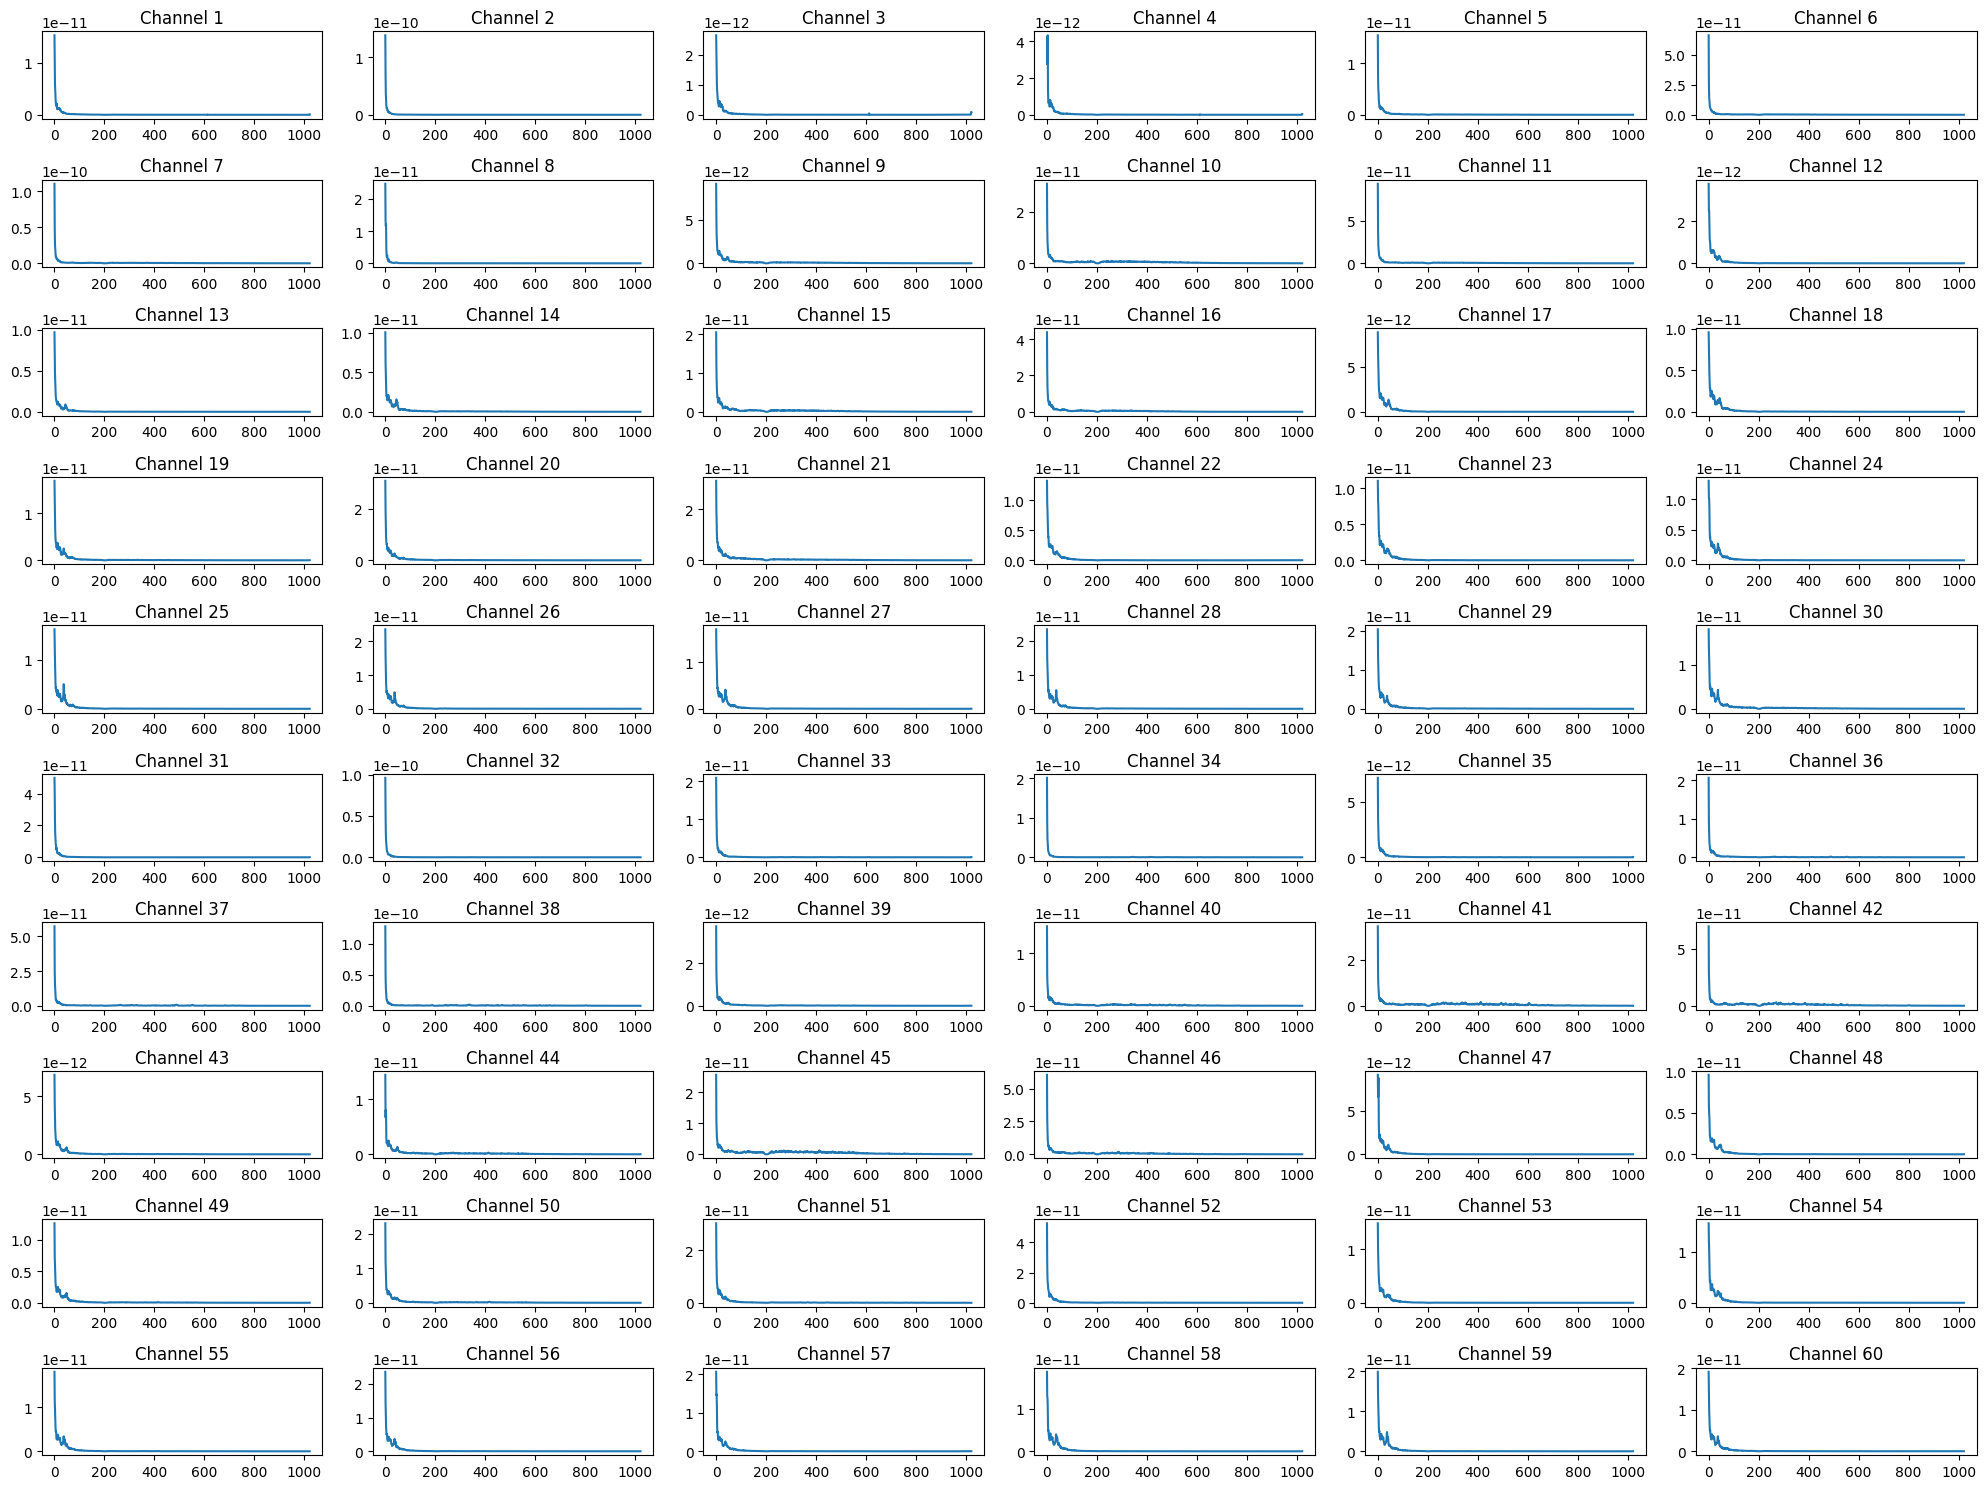

In [21]:
# plot 61 channels
plt.figure(figsize=(20, 15))

# create 10 x 6 grid
for i in range(1, 61):
    plt.subplot(10, 6, i)
    plt.plot(example[i])
    plt.title(f"Channel {i}")

# increase space between plots
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Channel 0')

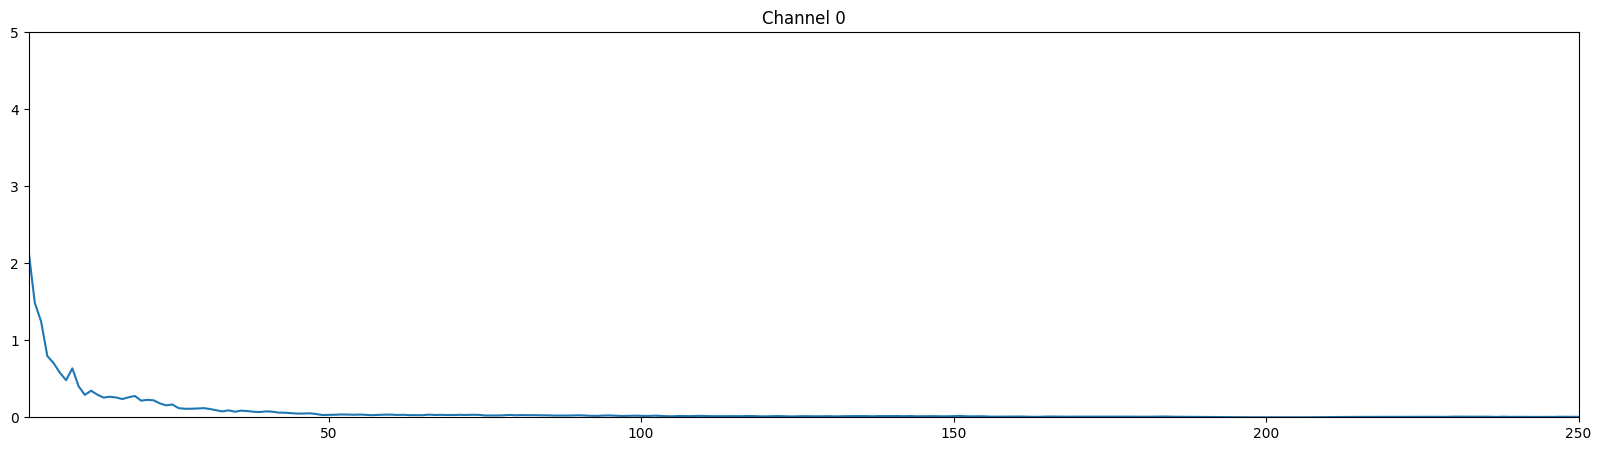

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(example[0] * 10e10)
plt.xlim(2, 250)
plt.ylim(0, 5)
plt.title(f"Channel 0")

Text(0.5, 1.0, 'Channel 36')

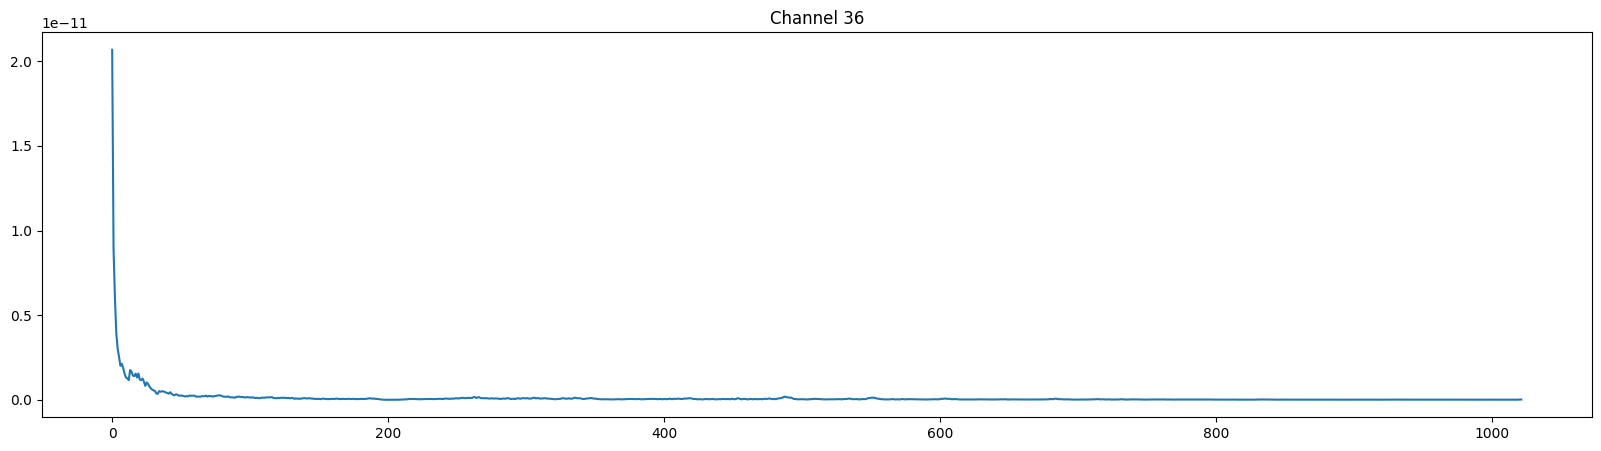

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(example[36])
plt.title(f"Channel 36")

Weird outlier like amplitude.

Text(0.5, 1.0, 'Channel 43')

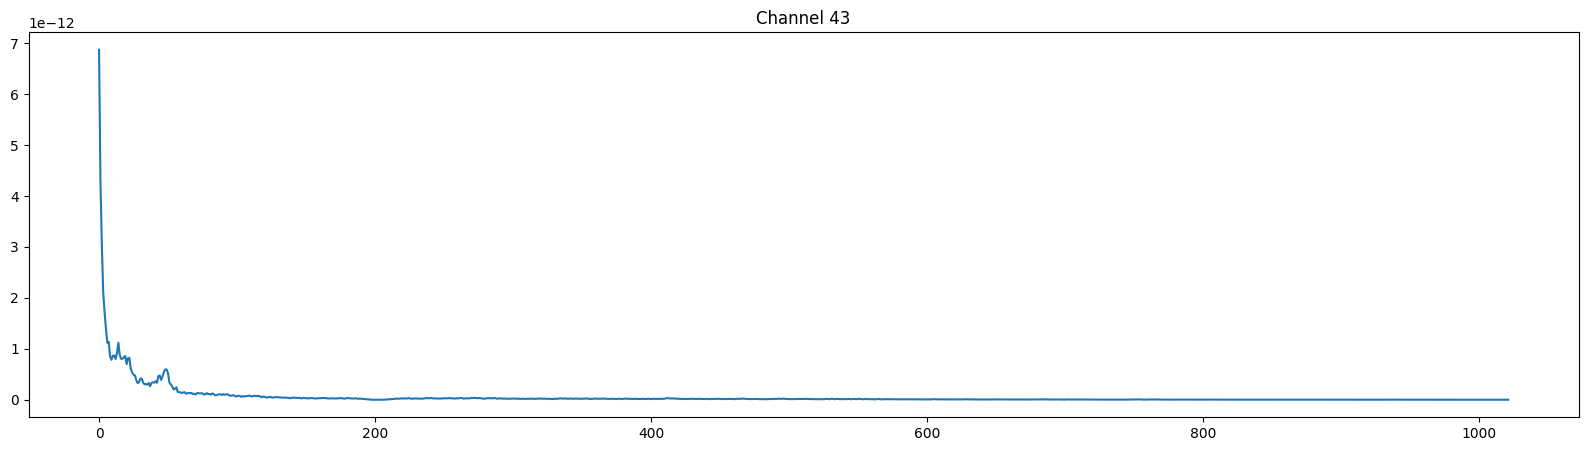

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(example[43])
plt.title(f"Channel 43")

Text(0.5, 1.0, 'Channel 7')

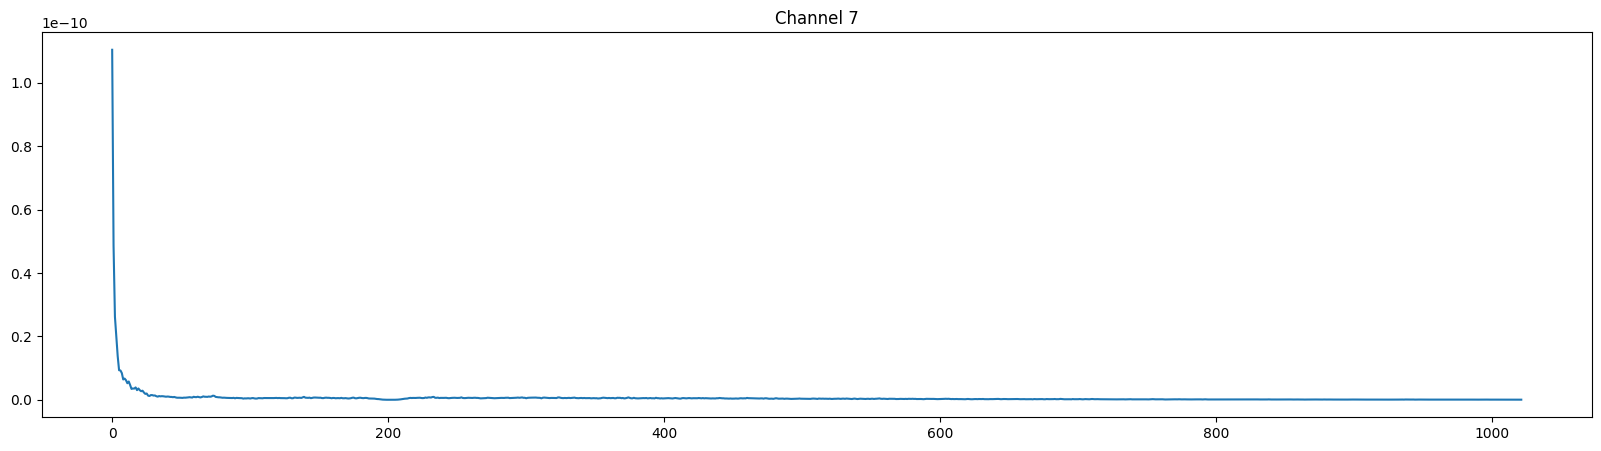

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(example[7])
plt.title(f"Channel 7")

### Attempt #2: fmin = 0.5, fmax = 250 (values chosen due to data analysis in 01 notebook). remove_dc = True and method = multitaper

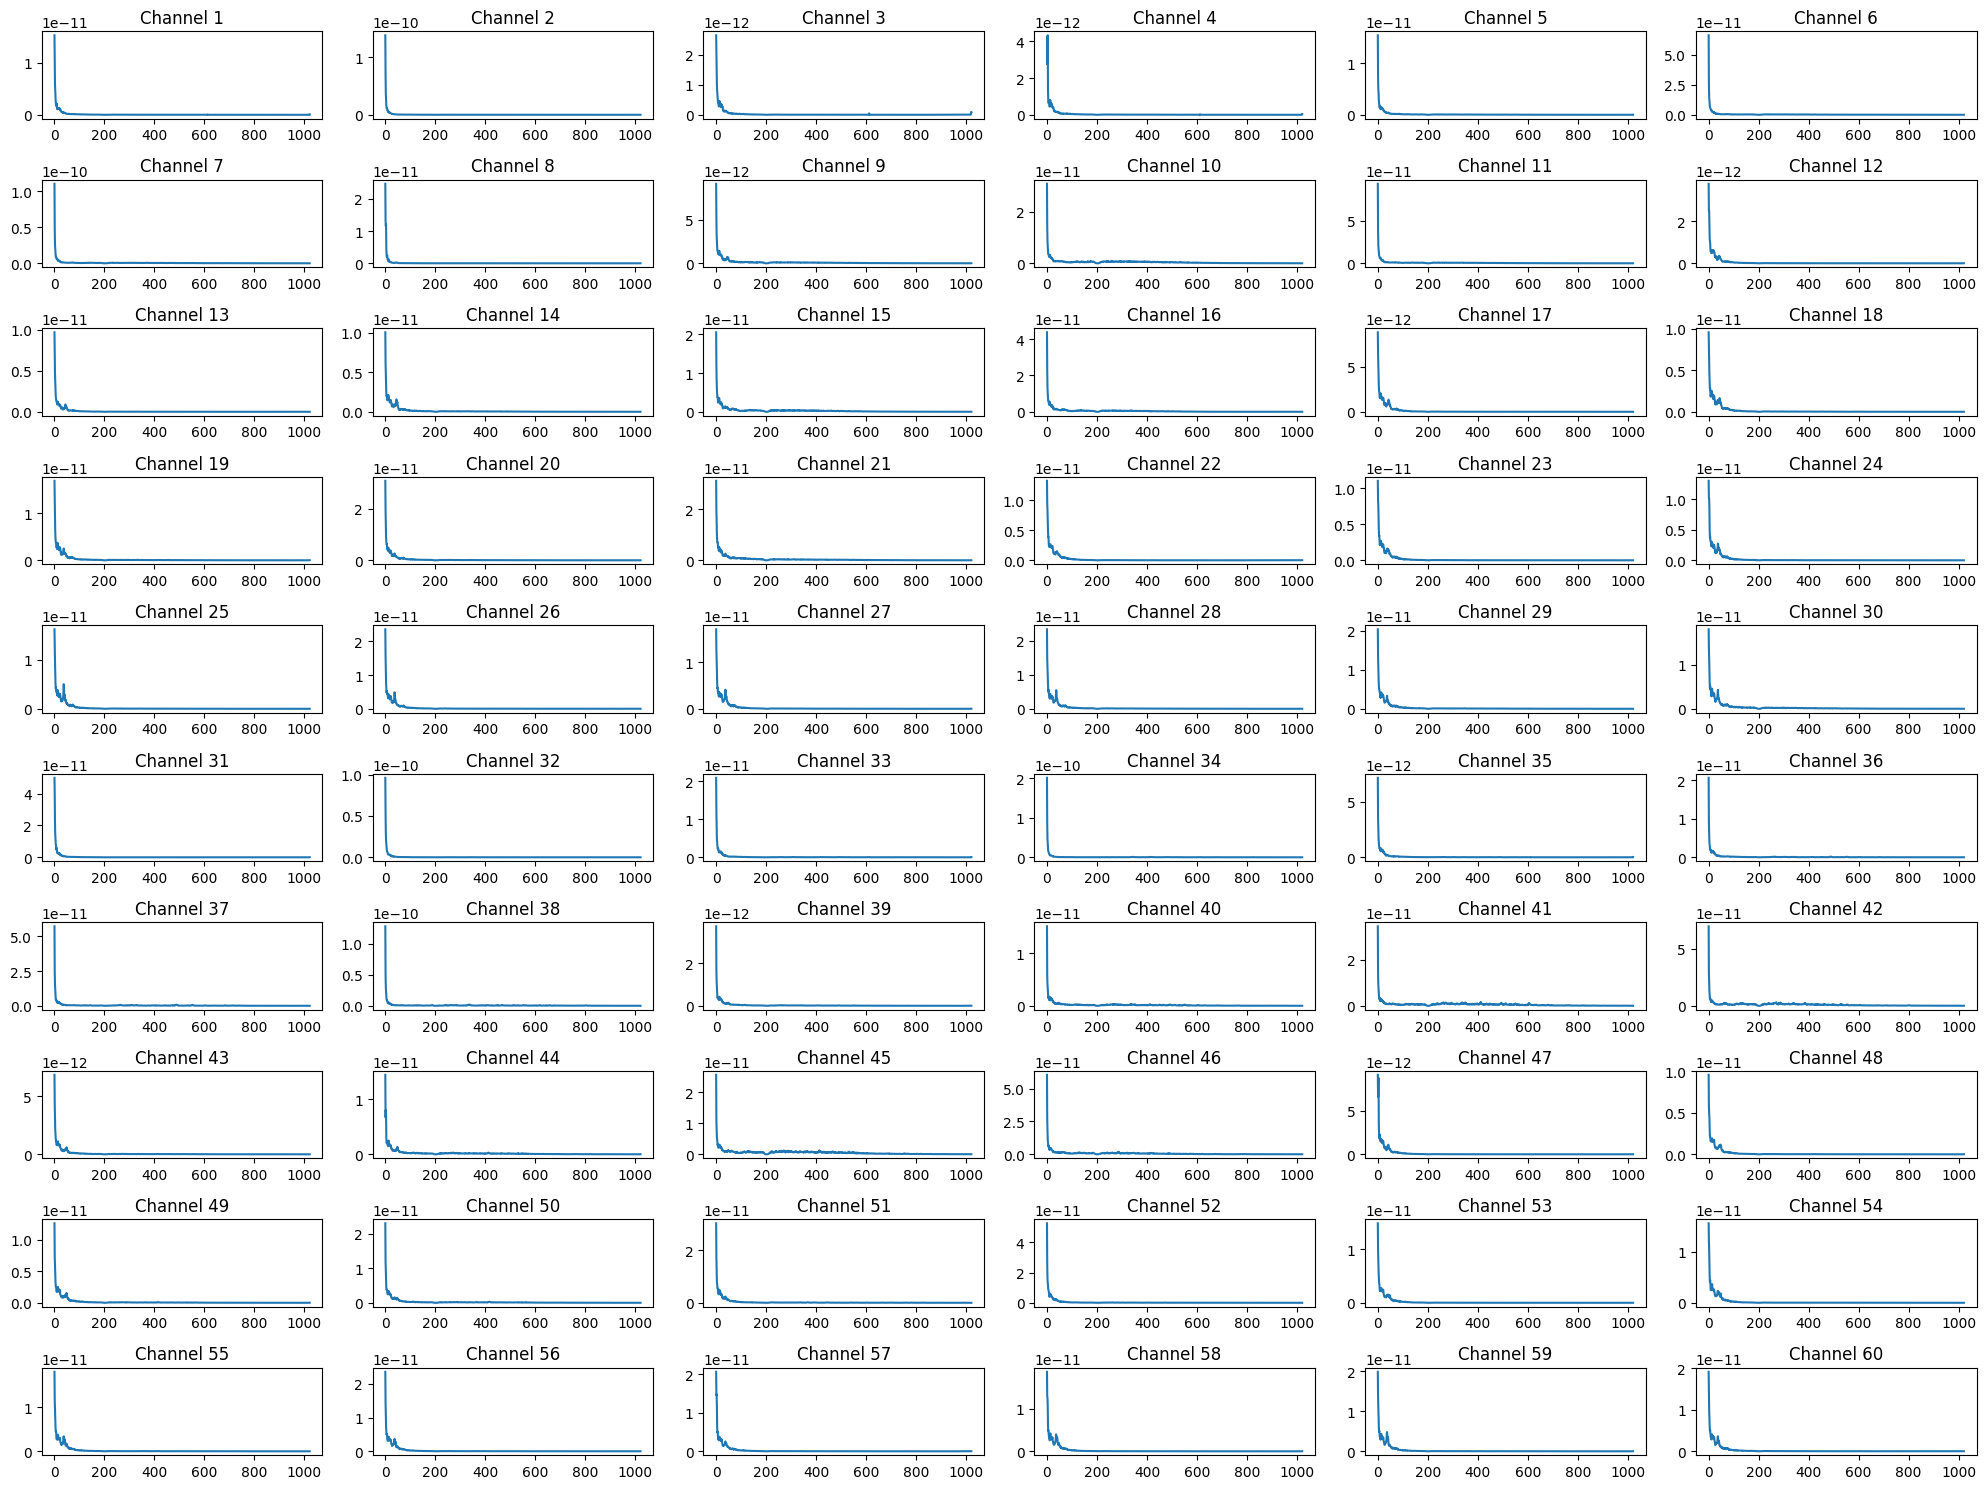

In [26]:
# plot 61 channels
plt.figure(figsize=(20, 15))

# create 10 x 6 grid
for i in range(1, 61):
    plt.subplot(10, 6, i)
    plt.plot(example[i])
    plt.title(f"Channel {i}")

# increase space between plots
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Channel 0')

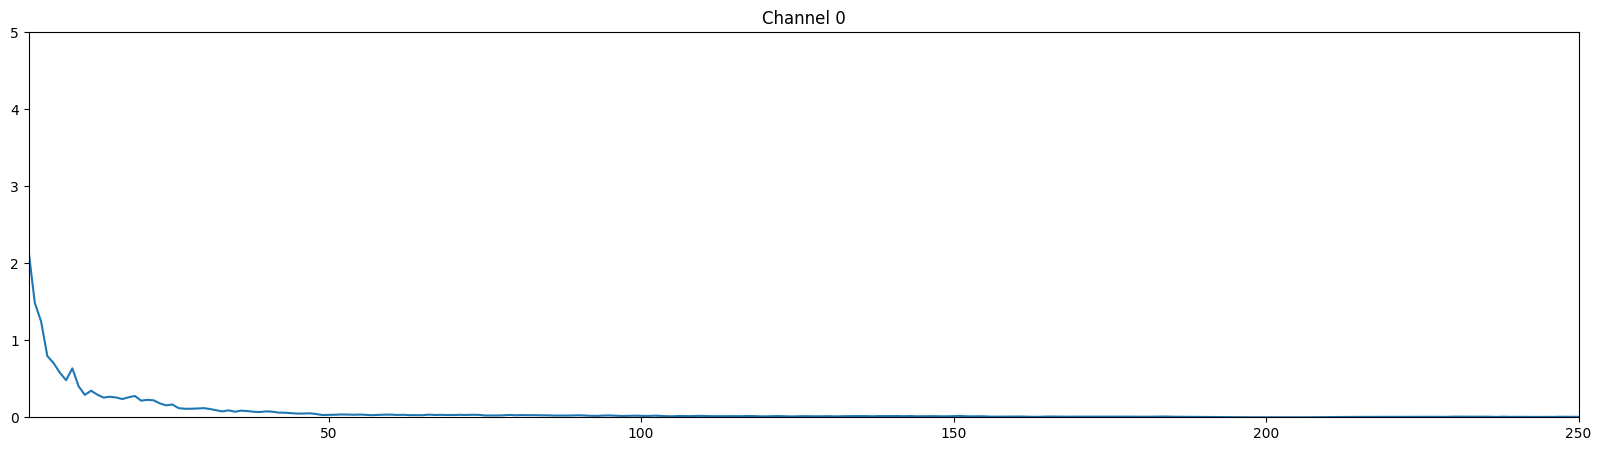

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(example[0] * 10e10)
plt.xlim(2, 250)
plt.ylim(0, 5)
plt.title(f"Channel 0")

## Min max values for time oriented data (not frequency)

Text(0.5, 1.0, 'Min and Max values of each channel')

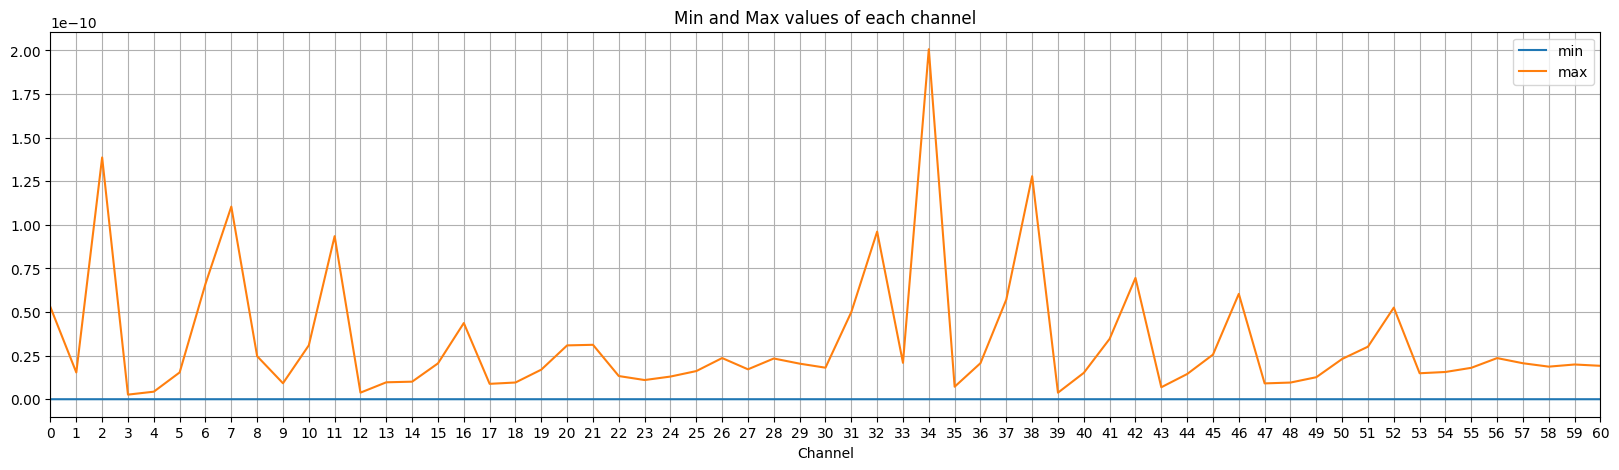

In [19]:
# get min and max values of the signal of each channel
min_values = [np.min(example[i]) for i in range(61)]
max_values = [np.max(example[i]) for i in range(61)]

plt.figure(figsize=(20, 5))
plt.plot(min_values, label='min')
plt.plot(max_values, label='max')
plt.legend()
plt.xlabel("Channel")
plt.xticks(range(0, 61))
plt.xlim(0, 60)

plt.grid()
plt.title("Min and Max values of each channel")
